## SuperMarket Data Challenge  
The dataset is the purchase record for a chain supermarket customers from January 2007 to December 2011.
The dataset contains informations:  
(1) House - store distances: the straight line distance from customer's house to the store for each customer.    
(2) Purchase info: for each customer, the purchase amount at a given store, the purchase amount for unique products at a given store，and the quantity.

The goal is to find any interesting evidence and actionable insights.

### 0. load in library

In [1]:
# python 2.7
import pandas as pd
import seaborn as sns
import numpy as np
#from scipy.stats import kendalltau
import matplotlib.pyplot as plt
%matplotlib inline

### 1.read in dataset

In [2]:
supermarket = pd.read_csv('/Users/Wei.Zhao/Documents/2017_INSIGHT/Interview code prepare/data challenges/super market/supermarket_data_aggr.csv')

* features:  
    customer_level:   
                customer_id,   
                (average,min,max) distance to shops,   
                shops_used    
    For each store and customer:   
                customer to store distance,  
                products_purchased,   
                unique products_purchased,  
                amount purchased,   
                average amount purchased,   
                average price 

### 2. Dataset restructure
  The structure of the original data frame is not convenient for exploratory data analysis. First, I am going to stack
stores info for each customer. I create a 'store' column for indicating store id .Please see store_has_purchase_df below. 

In [8]:
new_columns=['distance','products_purchased','unique_products_purchased','amount_purchased','avg_purchase','avg_price']
shops_dict={}
for i in range(1,6):
    shops_dict[i] = [k+'_shop_'+str(i) for k in new_columns]
store_info_df = pd.DataFrame(columns = ['store','customer_id']+new_columns)

In [10]:
for i,val in shops_dict.items():
    '''the new data frame will have columns: 
                                          customer id,
                                          distance, 
                                          store (e.g. 1,2,3,4,5),
                                          and for each store: 
                                          products purchased
                                          unique products purchased 
                                          amount purchased 
                                          average purchased 
                                          average price
    '''
    tmp_df =pd.DataFrame()
    tmp_df = supermarket[['customer_id'] + val].copy()
    tmp_df['store']=i
    column_name_dict={}
    for k,v in zip(new_columns, val):
        column_name_dict[v]=k
    tmp_df.rename(columns=column_name_dict,inplace=True)
    store_info_df = pd.concat([store_info_df,tmp_df])   

In [11]:
# change store type to string 
store_info_df[['customer_id','store']] = store_info_df[['customer_id','store']].astype(int)
store_info_df['store']=store_info_df['store'].astype(str)

In [13]:
# filter the rows with meaningful purchases.
store_has_purchase_df = store_info_df[store_info_df['amount_purchased']>1.0]
store_has_purchase_df.head(2)

,amount_purchased,avg_price,avg_purchase,customer_id,distance,products_purchased,store,unique_products_purchased
0,803.968,6.393403,10.441143,1,4082.5222,109.0,1,77.0
1,395.004,2.851152,3.761943,2,1115.3433,150.0,1,105.0


* I created the main dataset store_has_purchase_df to replace the original dataset.

### 3. Store level exploratory analysis to find problems

In [14]:
total_customers= store_has_purchase_df['customer_id'].nunique()
print "The total number of customers is %d." %(total_customers)

The total number of customers is 60338.


* It is interesting to look at revenue of each store by summing up the amount purchase at each store.

In [16]:
# calculate the sum of purchase amount at each store.
store_sum_df = store_has_purchase_df.groupby('store',as_index=False).sum()

# calculate the annual revenue for each store and converted to millions.
store_sum_df['amount_in_MM']= store_sum_df['amount_purchased'].apply(lambda x: x/5/100000)

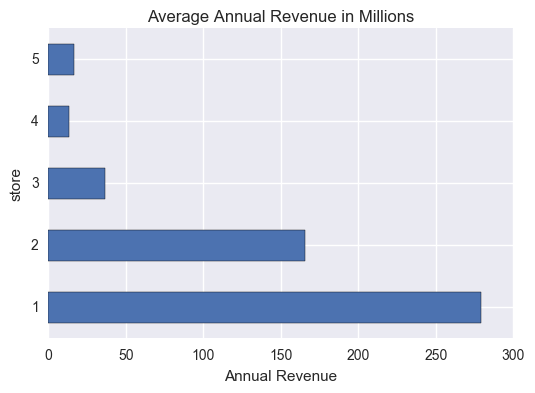

In [17]:
ax1 = store_sum_df.plot.barh(y='amount_in_MM',x='store', title='Average Annual Revenue in Millions',legend=False)
ax1.set_xlabel('Annual Revenue')

#### Store 1 has the highest revenue. The revenue is not balanced at all across 5 stores in this area. Store 1 has 10 times more revenue than store 5.  We should figure out where this difference comes from, because this is not an ideal situation for the reasons below:  
(1) If customers live close to store 3,4,5  shop in other chain stores, then we lose our customers.  
(2) If customers live close to store 3,4,5 and they still shop at store 1 and 2, the options will be either close     store 3,4,5 to decrease operational cost, or find a way for these stores to attract customers.  

#### Analysis:  
The analysis will be performed in three different directions based on the data set:  
(1) Location  
    Whether store 1 and 2 are located in a more populated area than store 3,4,and 5.
    - There are two ways to look into:  
    a. find the number of nearest neighbor customers for each store.  
      (assign a home store to each customers based on the closest distance)
    b. look at the distribution of customer to store distance for each store.
    
(2) Variety of products       
    Whether store 1 and 2 have more product types than store 3 and 4.


(3) Price  
    Whether store 1 and 2 have different price than store 3 and 4.
    


### 4. Looking into more details 

* An alternative to looking at the annual revenue, I can also look at the average purchase distribution at each store.

In [18]:
store_mean_df = store_has_purchase_df.groupby('store',as_index=False).mean()

In [19]:
store_mean_df.head(2)

,store,amount_purchased,avg_price,avg_purchase,customer_id,distance,products_purchased,unique_products_purchased
0,1,2512.453078,5.090521,8.806873,30710.329172,2489.514788,965.443219,241.736579
1,2,1853.925222,3.101312,6.714353,29417.585808,2234.132229,817.232668,170.921728


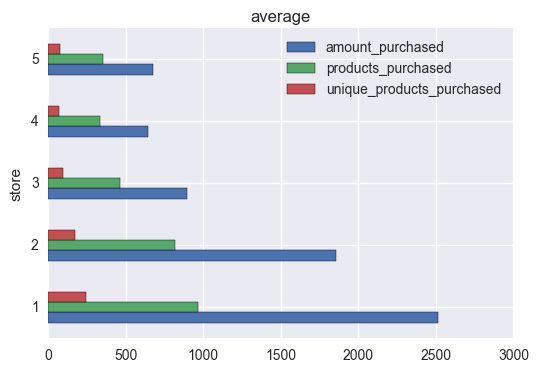

In [20]:
store_mean_df.plot.barh(y=['amount_purchased','products_purchased','unique_products_purchased'],
                        x='store',
                        title  = 'average')

* Customers spend more money in store 1 and 2, and purchased more kinds of products as well.

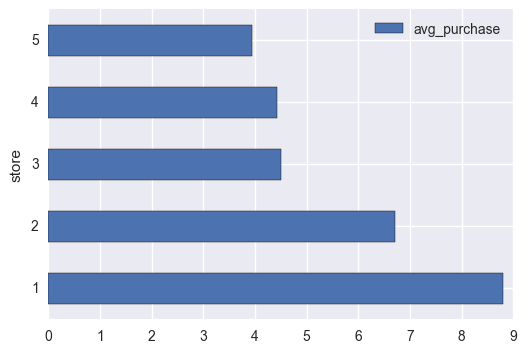

In [21]:
store_mean_df.plot.barh(y='avg_purchase',x='store')

* The graph shows the average purchase amount per item at each store. Store 1 and 2 sells more expensive items.

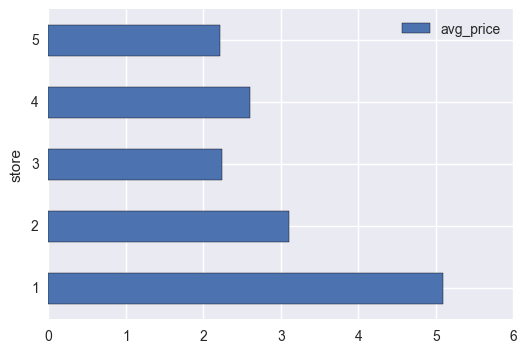

In [22]:
store_mean_df.plot.barh(y='avg_price',x='store')

* Just as the previous graph suggests, on average, products at store 1 cost more money. Without knowing the exact kind of products, we can assume the unique products at store 1(not sold in other stores) has higher price tag.

* It will be interesting to look at the average purchase distribution at each store.

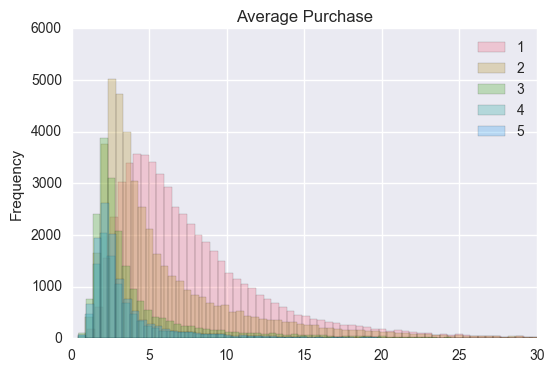

In [24]:
store_normal_purchase = store_has_purchase_df[store_has_purchase_df['avg_purchase']<50][['store','avg_purchase']]
sns.set_palette("husl")
ax = store_normal_purchase.groupby('store')['avg_purchase'].plot.hist(bins=100,alpha=0.3,xlim=[0,30],legend=True,
                                                                title ='Average Purchase')
    

* Customer indeed shop more expensive products at store 1 and store 2 rather than at the stores that are under performed.

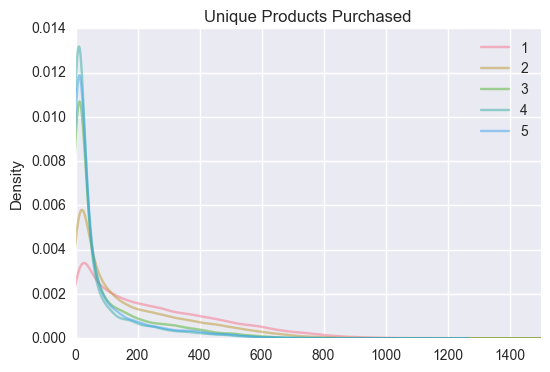

In [25]:
ax = store_has_purchase_df.groupby('store')['unique_products_purchased'].plot.kde(alpha=0.5,xlim=[0,1500],legend=True,
                                                                     title ='Unique Products Purchased')

* As previous graph suggests, customers buy more kinds of products at store 1 and 2.

### 5. Customer geographic analysic.
  * Why Customers spend more money at store 1 and 2? Because the neighhood of store 1 and 2 are richer? 
  * Are store 1 and 2 actually closer to more customers than store 3,4,5 so shopping at store 1 and 2 are more convenient?

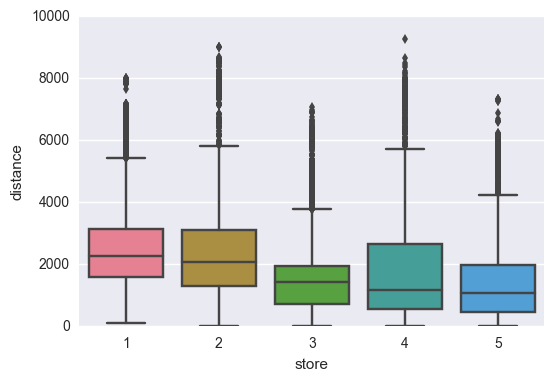

In [26]:
sns.set_palette("husl")
sns.boxplot(y='distance',x ='store',data=store_has_purchase_df)

* The figure above shows the distribution of customer to store distances for each store. The median customer distance to store is actually shorter for store 3,4,and 5 than store 1,2. But this graph does not tell us whether there are more customers live close to stores 1 and 2.

* The next cell of code assigns a home store for each customer based on straight line distance.

In [27]:
# find closet store for each customer by looking at distance column
nn_distance = store_has_purchase_df[['customer_id','distance']].groupby('customer_id', as_index=False).min()
# assign the closet store for each customer, e.g. if customer lives closes to store 1, store 1 is his/her "my store".
nn_distance = nn_distance.merge(store_has_purchase_df, how='left',on=['customer_id','distance'])

In [28]:
my_customers = nn_distance[['customer_id','store']].groupby('store',as_index=False).count()
my_customers.rename(columns={'customer_id':'num_NN_customers'},inplace=True)
num_customers = store_has_purchase_df[['store','customer_id']].groupby('store',as_index=False).count()
num_customers.rename(columns={'customer_id':'num_customers'},inplace=True)
store_mean_df = store_mean_df.merge(my_customers,on='store').merge(num_customers,on='store')

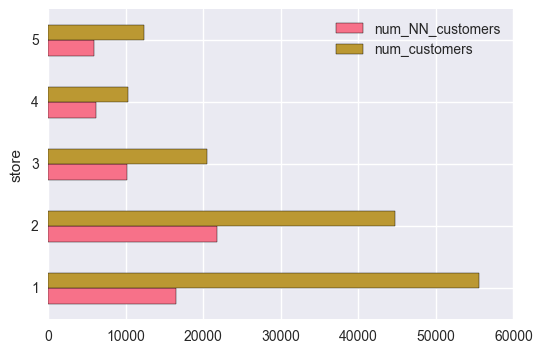

In [29]:
store_mean_df.plot.barh(y=['num_NN_customers','num_customers'], x='store')

* The figure above shows the number of customers live nearby (there is no other store that is closer to the customer than the store that we are looking at) as well as the total number of customers made purchase at a given store.
For most stores, the neighborhood customers are roughly 50% of the total customers. However, store 1 attracts customers outside of the neighborhood.

* From two graphs above, distance is not the major driving force for customers.

* It is interesting to look at fractional contribution to the store revenue based on distance between customers house to store.

In [35]:
def distance_identity(x):
    return int(x/1000) +1 if x<5000 else 5 
store_has_purchase_df.loc[:,'distance_id'] = store_has_purchase_df.loc[:,'distance'].apply(distance_identity)

def plot_percentage(id_col, store_num):
    store = store_has_purchase_df[store_has_purchase_df['store'] == store_num]
    store_summary = store[['amount_purchased',id_col]].groupby(id_col,as_index=False).sum()
    total_revenue = store_summary['amount_purchased'].sum()
    store_summary.loc[:,'percentage'] = store_summary.loc[:,'amount_purchased'].apply(lambda x: int(x/total_revenue*100))
    store_summary = store_summary.set_index(id_col)
    
    
    ax = store_summary.plot.pie(y='percentage',title = 'store'+i, 
                                autopct='%.2f', labels=['','','','',''],
                                colormap = 'Set2')
    
    
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(['< 1000m ','1000 - 2000 m','2000-3000 m','3000 - 4000 m','> 5000 m'],
             bbox_to_anchor=(0.9, 1), loc=2, borderaxespad=0.)
    plt.axis('equal')

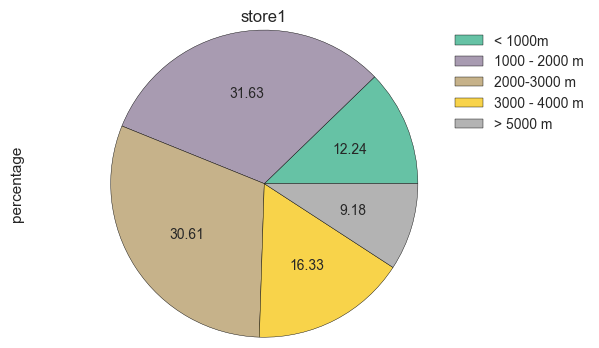

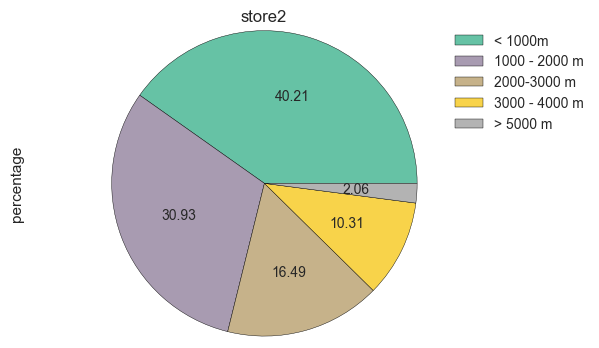

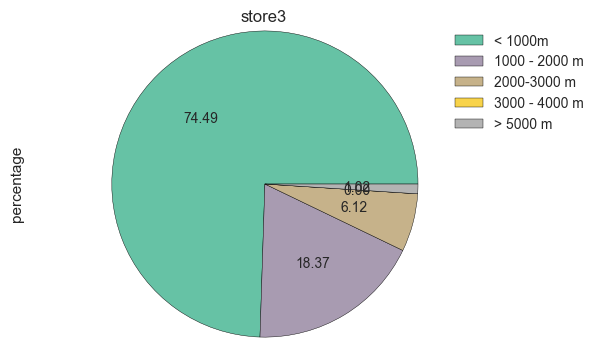

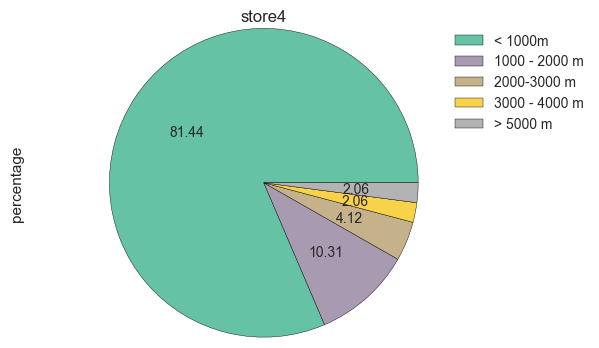

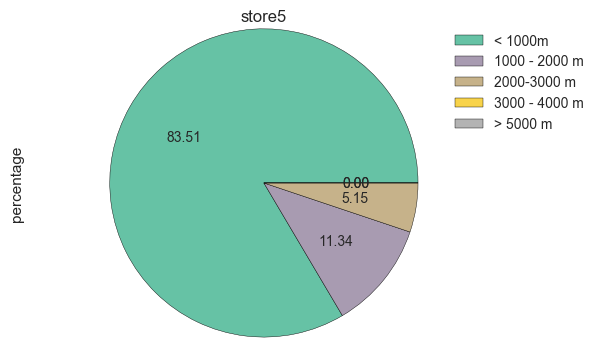

In [36]:
store_list =['1','2','3','4','5']
for i in store_list:
    plot_percentage('distance_id',i)

*  Here is the most significant contrast between super star stores and stores under performed. Most purchases are made by customers live in the neighborhood for stores 3,4 and 5. However, customers are willing to drive long distance to stores 1 and 2, and buy expensive products there.

* Let's look at the fraction of customers live near one store and shop at other stores

In [37]:
nn_distance.rename(columns={'store':'home_store'},inplace=True)

In [38]:
home_store = store_has_purchase_df.merge(nn_distance[['customer_id','home_store']],on='customer_id')

In [39]:
def shop_stores(homestore,store):
    homestore_customers = pd.DataFrame()
    homestore_customers = home_store[home_store['home_store'] == homestore]
    homestore_customers_count = homestore_customers['customer_id'].nunique()
    shop_at_store_count = homestore_customers [homestore_customers['store']==store]['customer_id'].nunique()
    return shop_at_store_count*100.0 / homestore_customers_count

In [40]:
customers = np.zeros([5,5])
for j in range(5):
    for k in range(5):
        customers[j][k] = shop_stores(str(j+1),str(k+1))     # home store, shop store

In [41]:
customers_shop_at_store = pd.DataFrame(customers,columns=['store_'+str(i+1) for i in range(5)],index=['home store_'+str(i+1) for i in range(5)])

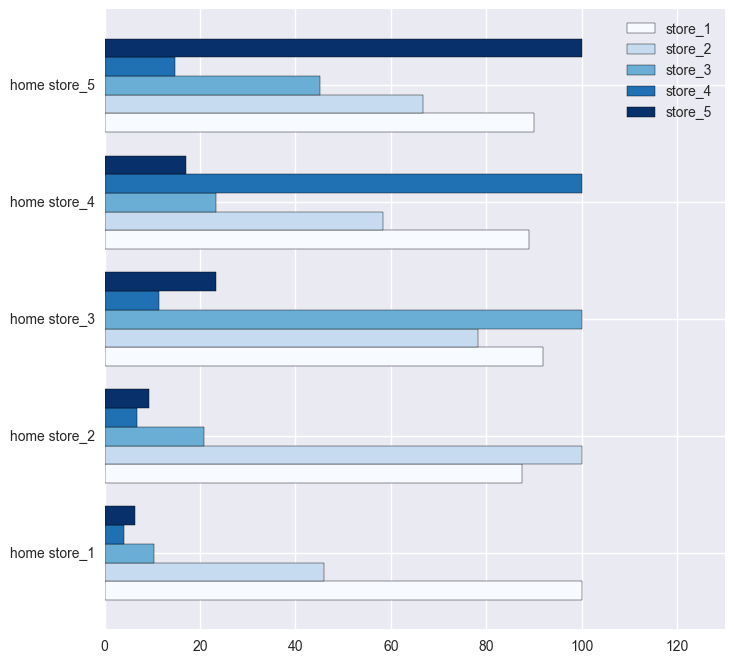

In [42]:
ax2 = customers_shop_at_store.plot.barh(xlim=[0,130],figsize=[8,8],width=0.8,colormap='Blues')


* The figure above shows that customers who live close to store 1 will sometimes shop at store 2, but have a fair low chance to shop at stores 3,4,and 5.  
* In contrast, customers who live close to store 3,4,5 shop nearly as frequenlyt as they shop at stores 1 and 2. Could it be possible that store 3,4,5 are actually further away than the straight line distance? 
* Customers do not drive far for nothing. They either shop for products that are not available at their home stores, or shop for deals. 

* Let's investigate why customers live near store 3,4,and 5 want to shop at 1 or 2.  
  First, I select customers assigned with 3 or 4 or 5 as their home store.  
  Second, I compare their purchase at store 3 or 4 or 5 (labeld as "near") to their purchase at store 1 or 2 (labeled as "far"). 

In [43]:
far_customers = home_store[(home_store['home_store'].isin(['3','4','5']))]
num_far_customers = far_customers['customer_id'].nunique()
far_customers.loc[:,'drive'] =  far_customers.loc[:,'store'].apply(lambda x: 'far' if x in ['1','2'] else 'near')

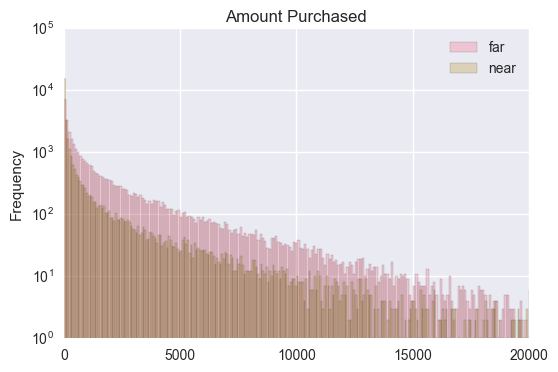

In [45]:
ax = far_customers.groupby('drive')['amount_purchased'].plot.hist(bins=500,alpha=0.3,xlim=[0,20000], logy=True,legend=True,
                                                                     title ='Amount Purchased')
            


* The y axis of the graph above is in log scale. Customers spent more money when they shop at stores far away. That tells us
the sales at store 3,4 and 5 are bad not because they are in poor neighborhood. 

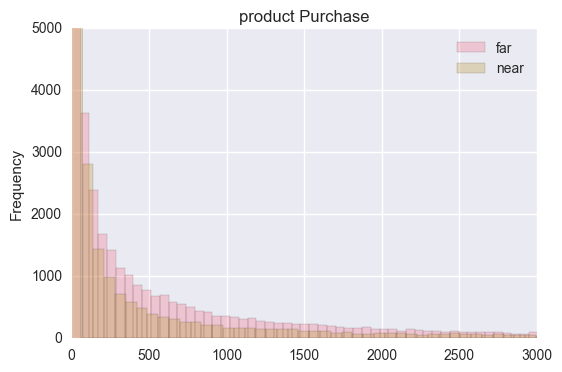

In [47]:
ax = far_customers.groupby('drive')['products_purchased'].plot.hist(bins=300,alpha=0.3,xlim=[0,3000],ylim=[0,5000],legend=True,
                                                                     title ='product Purchase')

* The figure shows that customers also bought more products at stores 1 and 2.

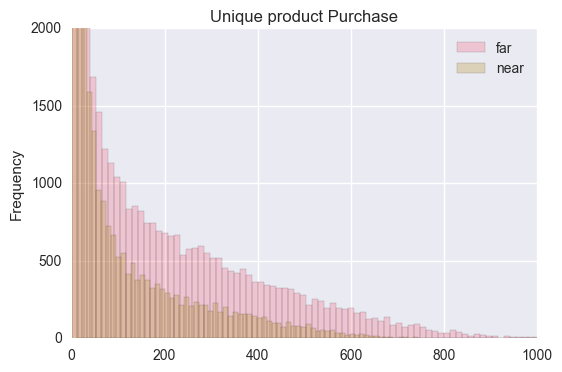

In [48]:
ax = far_customers.groupby('drive')['unique_products_purchased'].plot.hist(bins=100,alpha=0.3,xlim=[0,1000],ylim=[0,2000],legend=True,
                                                                     title ='Unique product Purchase')

* Comparing this graph to the graph before sugguests the major driving force for customers to go to stores 1 and 2 are unique products that are not available at their local stores!

## Conclusion

It is found that across the region that we are interested, the revenue of 5 stores are not balanced at all. Stores 3, 4, and 5 siginificantly under perform than stores 1 or 2. Three directions are explored to find the major reason why these stores have weak sales:

The revenue for the store is not proportional to the local population under straight line distance assumption.
The low sales record is not because they are in a poor neighborhood.

That means there are people live in the area, but they don't spend as much money in their local store. In fact, customers shop as frequently at remote stores as they shop at their local stores. They shop more unique products at stores 1 and 2 and spend more money there. These unique products on average have higher price tag that leveraging the revenue for store 1 and 2.

The suggested actions for next step would be to find out what are the popular unique products at store 1 and 2 that are not available at other stores, and stock these products to their shelves.